引入套件

In [2]:
# 會用到的套件
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

繪圖相關設定

In [3]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體

# 設定文字雲中文字體路徑
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型

### 資料介紹
資料來源：
+ TarFlow 蒐集PTT 房屋版 文章
+ 關鍵字：房價
+ 時間： 2024-03-01 ~ 2025-3-01
+ 資料筆數：共 5195 篇文章

讀取ptt檔案ptt_house_price.csv

In [32]:
df = pd.read_csv('raw_data/ptt_house_price.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/home-sale/M.1709249161....,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,jump0517,home_sale,連結：\nhttps://money.udn.com/money/story/5621/78...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fatpigbgman""...",1.168.65.178,2024-03-02 01:42:37,ptt
1,2,https://www.ptt.cc/bbs/home-sale/M.1709251729....,[情報]好房網2月房價,2024-03-01 08:08:47,linlinme5208,home_sale,好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ChennBZ"", ""c...",211.20.144.117,2024-03-02 01:42:37,ptt
2,3,https://www.ptt.cc/bbs/home-sale/M.1709255830....,Re:[情報]好房網2月房價,2024-03-01 09:17:08,junior020486,home_sale,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hellogym"", ""...",49.216.24.218,2024-03-02 01:42:37,ptt
3,4,https://www.ptt.cc/bbs/home-sale/M.1709260904....,[閒聊]基隆是台北之外最不可能蓋GG的嗎,2024-03-01 10:41:42,Austenite,home_sale,最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""wwrest"", ""cm...",1.163.246.7,2024-03-02 01:42:37,ptt
4,5,https://www.ptt.cc/bbs/home-sale/M.1709263369....,[請益]預售屋可否負擔,2024-03-01 11:22:47,mosfets,home_sale,各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""JohnLackey"",...",39.9.32.99,2024-03-02 01:42:37,ptt


### 資料初步清理
- 清除內文為空值的文章

- 透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號。

- 清除不重要的字如換行、網址

In [33]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artUrl', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True) # 若inplace=False會回傳新的Dataframe，需要賦值接它

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)
# 將換行符號\r取代為句號
# clear_df['sentence'] = clear_df['sentence'].str.replace(r'\r','。', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

,artTitle,artDate,artContent,sentence
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結：， 駁斥養地炒房說。媒體報導，具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地，得標...
1,[情報]好房網2月房價,2024-03-01 08:08:47,好房網 重點縣市成交漲跌排行\nhttps://price.housefun.com.tw/...,好房網 重點縣市成交漲跌排行， ->區域實價登錄趨勢。2024年。2月，重點縣市實價登錄漲跌...
2,Re:[情報]好房網2月房價,2024-03-01 09:17:08,你們那個要買新竹熱區的手腳要快\n新竹現在很誇張\n外圍補漲的很兇\n前幾天星XX超開價成交...,你們那個要買新竹熱區的手腳要快，新竹現在很誇張，外圍補漲的很兇，前幾天星XX超開價成交後，環...
3,[閒聊]基隆是台北之外最不可能蓋GG的嗎,2024-03-01 10:41:42,最近各縣市都被點名要蓋GG\n高雄 台中 嘉義 虎尾\n被點名出列的房價都開始漲\n\n基隆...,最近各縣市都被點名要蓋GG，高雄 台中 嘉義 虎尾，被點名出列的房價都開始漲。基隆484永遠...
4,[請益]預售屋可否負擔,2024-03-01 11:22:47,各位前輩好\n\n小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想...,各位前輩好。小弟目前在竹科工作 覺得新竹房價越來越高 因為工作快三年 有些自備款 有想先上車...
5,[請益]建議用二胎房貸嗎？,2024-03-01 11:50:06,是這樣的，我目前的房屋是在三年前買的\n\n使用 40 年房貸 / 寬限期 5 年\n\n目...,是這樣的，我目前的房屋是在三年前買的。使用 40 年房貸 / 寬限期 5 年。目前還在寬限期...
6,[新聞]小坪數買氣夯？全台「小宅」驚人空屋率曝,2024-03-01 11:58:52,小坪數買氣夯？全台「小宅」驚人空屋率曝光\n\nTVBS 記者 陳文越 / 攝影 鍾德榮 報...,小坪數買氣夯？全台「小宅」驚人空屋率曝光。TVBS 記者 陳文越 / 攝影 鍾德榮 報導。房...
7,[請益]掛4買第三間是否可行,2024-03-01 12:26:34,各位前輩好\n\n小弟目前在高雄工作 覺得高雄房價越來越高\n且這一波預售都還在漲，之後想必...,各位前輩好。小弟目前在高雄工作 覺得高雄房價越來越高，且這一波預售都還在漲，之後想必會把中古...
8,[新聞]月收72K想買988萬新成屋 過來人警1事：,2024-03-01 13:57:55,連結：\nhttps://bit.ly/49Ts3Zn\n內文：月收72K想買988萬新成屋...,連結：， 過來人警1事：房貸比房東無情。在眾多台灣年輕人面臨的生活議題中，「是否應該購房」一...
9,[請益]政府機關大樓對週邊房市的影響,2024-03-01 16:28:34,https://news.ltn.com.tw/amp/news/life/breaking...,from MeowPtt on my iPhone。


### 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [34]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

,artTitle,artDate,artContent,sentence
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結：
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥養地炒房說
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體報導
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地
4,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,得標後不開發
5,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養
6,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,放數年再加價轉售給建商賺價差
7,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣金聯今天澄清
8,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,絕不炒作房價也未曾炒作土地
9,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,土


### 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。
Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。   
另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [35]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('dict/dict.txt')

斷詞前先將標點符號清除，並清除空字串


***正規表達式 (Regular Expression)*** 是透過簡單的特定字符規則，從文本中找尋符合對應規則的字串，幾乎常見的程式語言，都有支援正規表達式的操作。   

以下提供幾個範例：   

+ ```\d```：匹配任何一個數字字符，等同於 [0-9]

+ ```\w```：匹配任何一個單詞字符，包括字母、數字和下劃線，等同於 [a-zA-Z0-9_]

+ ```\s```：匹配任何一個空白字符，包括空格、換行等

+ ```[ ]```：用於定義一個字符集合，匹配集合中的任何一個字符。 例如: [abc] = 匹配字符 a、b 或 c。

+ ```[^ ]```：用於定義一個否定字符集合，匹配不在集合中的任何一個字符。 例如: [^abc] = 匹配除了 a、b 和 c 以外的任何字符。

+ ```+```：匹配前面提及的元素一次或多次。

更多有關正規表達式的用法可參考python官網的[介紹](https://docs.python.org/zh-tw/3/library/re.html)

In [36]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

,artTitle,artDate,artContent,sentence
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥養地炒房說
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體報導
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具公股色彩的台灣金聯近年大舉在南台灣與建商競標土地
4,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,得標後不開發
6,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,放數年再加價轉售給建商賺價差
7,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣金聯今天澄清
8,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,絕不炒作房價也未曾炒作土地
10,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,地未運用是前期作業尚未完成
11,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,並非養地


使用jieba進行斷詞

In [37]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

word_df.head(10)

Building prefix dict from e:\中山資管碩\碩一下學期\社媒\2025-SMA-Study-Group-8\dict\dict.txt ...
Loading model from cache C:\Users\paul\AppData\Local\Temp\jieba.u3c145057bb1ef3916e65da93bba4808e.cache
Loading model cost 0.790 seconds.
Prefix dict has been built successfully.


,artTitle,artDate,artContent,word
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,說
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,公股


#### 為了進行前後比較，先透過繪製詞頻圖及文字雲觀察一下目前的資料。

### 計算去除停用字及更新字典前的詞頻

In [38]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

,word,count
0,,47112
1,的,46265
2,是,16133
3,有,10437
4,了,9898
5,也,9777
6,都,9482
7,房價,9355
8,在,9087
9,就,8962


### 4.6 視覺化結果

matplotlib 畫圖中文顯示不出來的問題

* Mac : <a href="https://blog.csdn.net/RivenDong/article/details/118990773">參考方式</a>
* Windows : <a href="https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b">參考方式</a>
* 暫存查找 path 方式：matplotlib.get_cachedir()

#### 繪製詞頻為前10高的長條圖

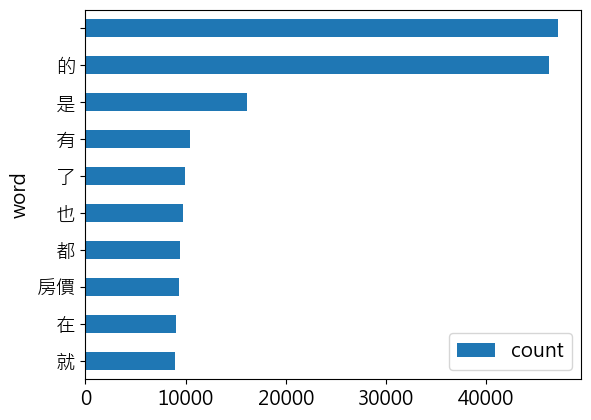

In [39]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 繪製文字雲

In [40]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count'] # 取得 count 對應的內部字典

print(dict(list(freq_dict.items())[:10]))

{' ': 47112, '的': 46265, '是': 16133, '有': 10437, '了': 9898, '也': 9777, '都': 9482, '房價': 9355, '在': 9087, '就': 8962}


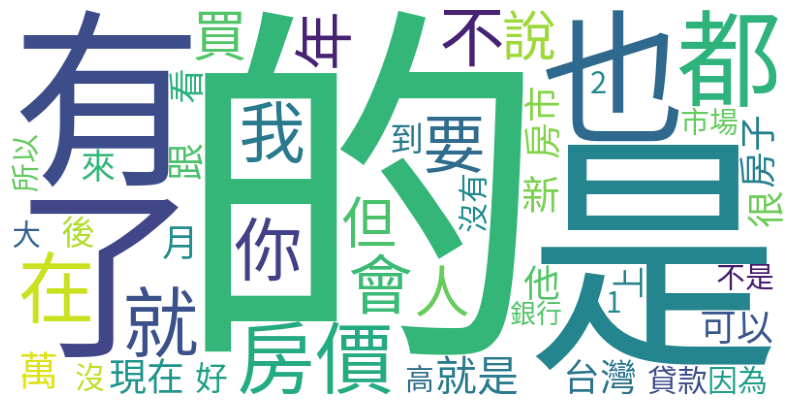

In [41]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

發現斷詞有許多一個字的結果，這些字對後續分析沒有意義，因此先去除斷詞結果少於兩個字的資料。

In [42]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

計算詞頻並繪製長條圖

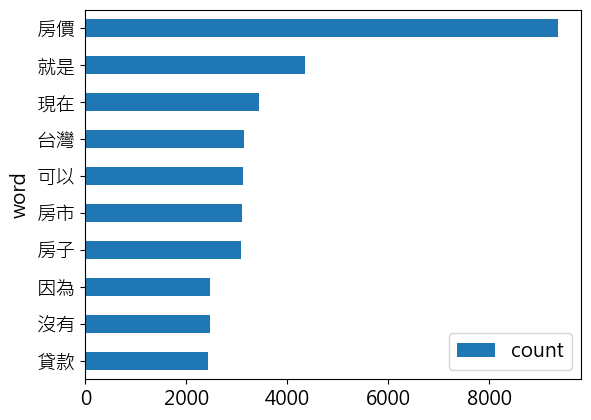

In [43]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()

plt.show()

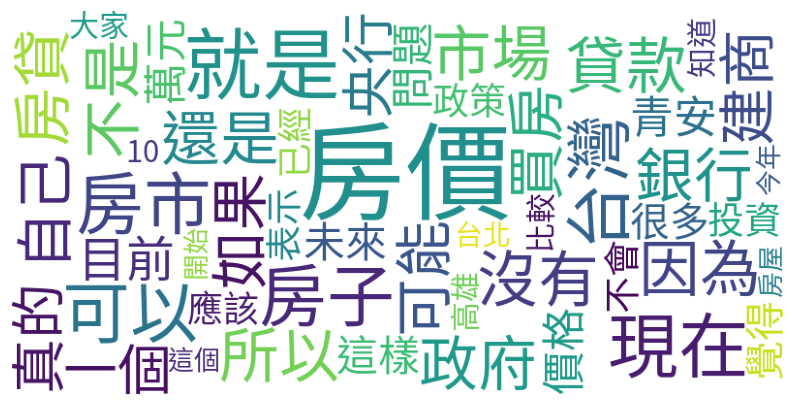

In [44]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

### 4.7 移除停用字

目前資料中還是有許多對後續分析沒有幫助的無意義詞彙，這些詞稱為停用字，接下來會清除這些停用字。

In [45]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除dataframe中的停用字

In [46]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

,artTitle,artDate,artContent,word
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,公股
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,色彩
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,金聯


### 計算去除停用字後的詞頻

#### 再次繪製長條圖

C:\Users\paul\AppData\Local\Temp\ipykernel_26120\583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


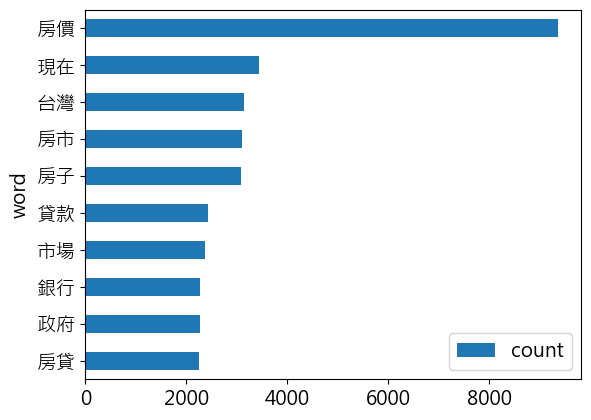

In [47]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 再次繪製文字雲

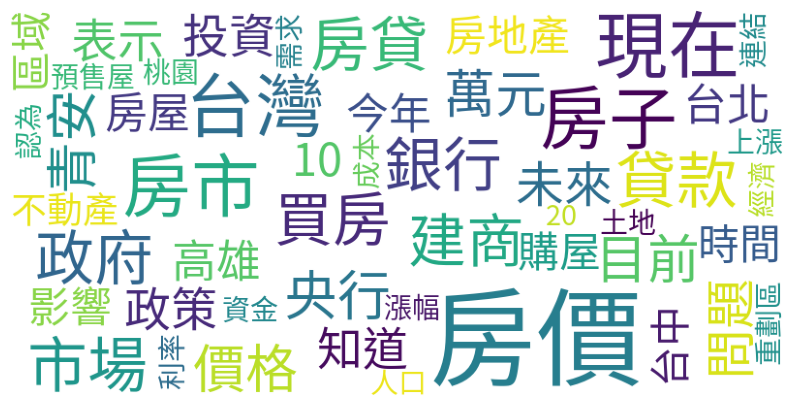

In [48]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

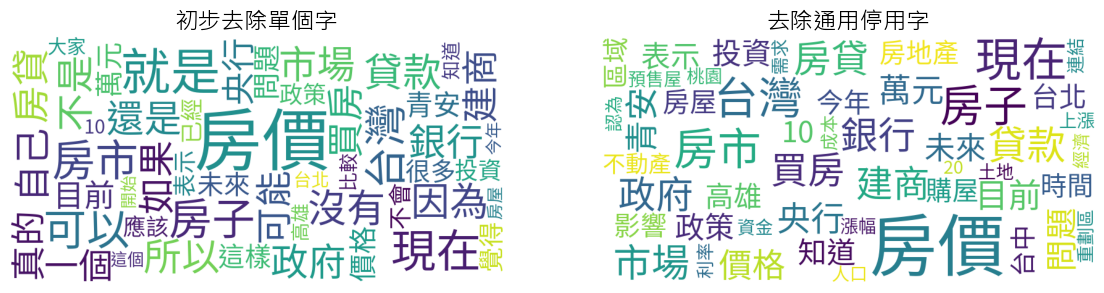

In [49]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

### 4.8 更新停用字字典

In [78]:
# 參數形式手動加入停用字
stopwords_manual = ["連結", "現在", "目前", "認為", "持續", "一直", "時間", "這種", "表示", "看到", "去年", 
                    "知道", "字頭", "根本", "地方", "平均", "今年"]
stopwords.extend(stopwords_manual)

In [79]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

,artTitle,artDate,artContent,word
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,公股
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,色彩
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,金聯
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,近年


#### 再次繪製文字雲

C:\Users\paul\AppData\Local\Temp\ipykernel_26120\1032659861.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


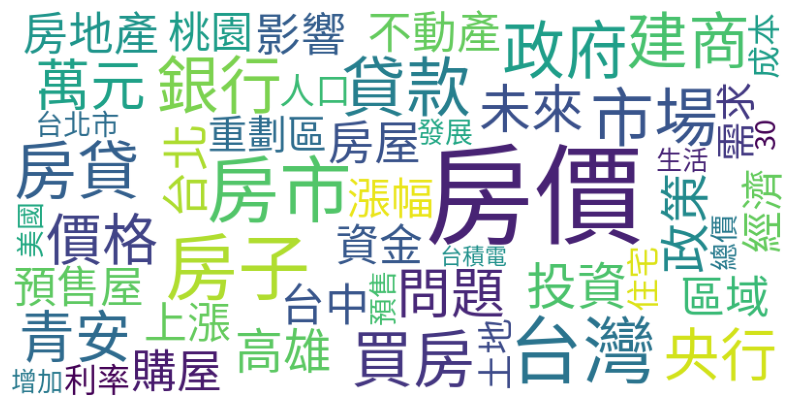

In [80]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()

透過文字雲看一下目前為止做的文字處理結果有什麼差異

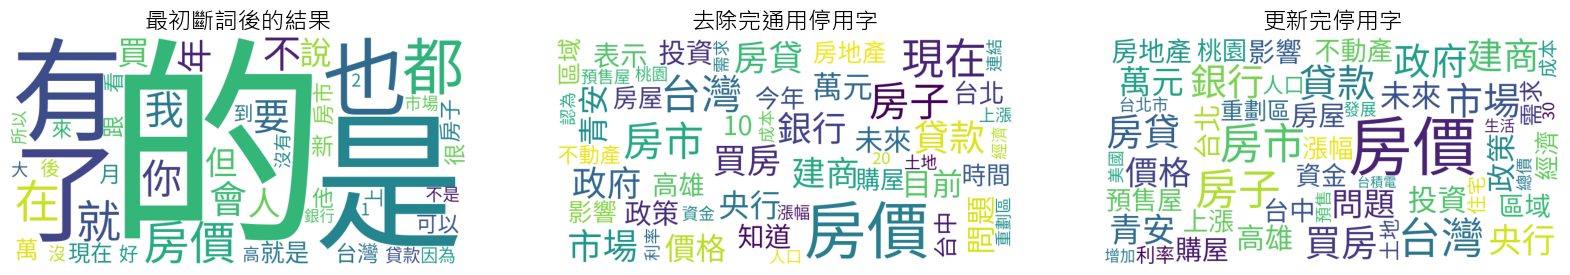

In [81]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

### 更新斷詞字典

萬元應該前面會有一個數字，變成組合詞，如:30萬元...

In [ ]:
sent_df["sentence"] = sent_df["sentence"].replace({'': ''}, regex=True)
sent_df.head(10)

,artTitle,artDate,artContent,sentence
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥養土地炒房說
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體報導
3,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,具公股色彩的台灣金聯近年大舉在南台灣與建商競標土土地土地
4,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,得標後不開發
6,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,放數年再加價轉售給建商賺價差
7,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,台灣金聯今天澄清
8,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,絕不炒作房價也未曾炒作土土地土地
10,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,土地未運用是前期作業尚未完成
11,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,並非養土地


#### 重新斷詞

In [90]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]
word_df_updated

,artTitle,artDate,artContent,word
0,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,連結
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
...,...,...,...,...
206089,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,賣方
206090,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,比起
206090,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,先前
206090,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,姿態


#### 重新移除停用字

In [91]:
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated

,artTitle,artDate,artContent,word
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,駁斥
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,養地
1,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,炒房
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,媒體
2,[新聞]台灣金聯：土地未運用有原因駁斥養地炒,2024-03-01 07:25:58,連結：\nhttps://money.udn.com/money/story/5621/78...,報導
...,...,...,...,...
206088,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,拉長
206089,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,賣方
206090,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,先前
206090,[新聞]台積電高雄廠掛牌啟動在地曝:輪班仔先,2025-03-01 18:43:13,台積電高雄廠掛牌啟動 在地曝：輪班仔先選車貸不買房\n\n記者張雅雲／高雄報導\n台積電高雄...,姿態


In [92]:
nostop_df_updated[nostop_df_updated['word'] == ('萬元')]['word'].count()

1997

將字詞加入斷詞字典中可以設定該詞的詞頻，如果一個新詞的詞頻較高，它將更有可能被視為一個獨立的單詞，而不是被切分為多個子詞。   

接下來我們試試看在斷詞字典中加入詞頻的話會怎麼樣

In [ ]:
jieba.del_word('麻辣火鍋') # 先將‘麻辣火鍋’字詞從斷詞字典中移除
jieba.add_word('麻辣火鍋', freq = 100)  # 加上詞頻後重新加入斷詞字典

重新進行斷詞及清除停用字

In [ ]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]

#去除停用字
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated.head(10)

,artTitle,artDate,artContent,word
0,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,濃咖哩
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2019
1,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,112
2,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,2010
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,提供
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,文章
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,不予
3,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,保留
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,多訪
4,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\r\n 消費時間：2019年1/12月\r\n (例...,綜合


In [ ]:
# 查看調整詞頻之後‘麻辣火鍋’出現幾次
nostop_df_updated[nostop_df_updated['word'] == ('麻辣火鍋')]['word'].count()

50

經過比對可以看到該詞的數量上升，代表該詞更加精準地被拆分了出來。

#### 重新計算詞頻

In [93]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated.head(10)

C:\Users\paul\AppData\Local\Temp\ipykernel_26120\1450957720.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


,word,count
0,房價,9355
1,台灣,3147
2,房市,3100
3,房子,3092
4,貸款,2437
5,市場,2379
6,銀行,2274
7,政府,2268
8,房貸,2250
9,建商,2213


#### 重新繪製詞頻長條圖

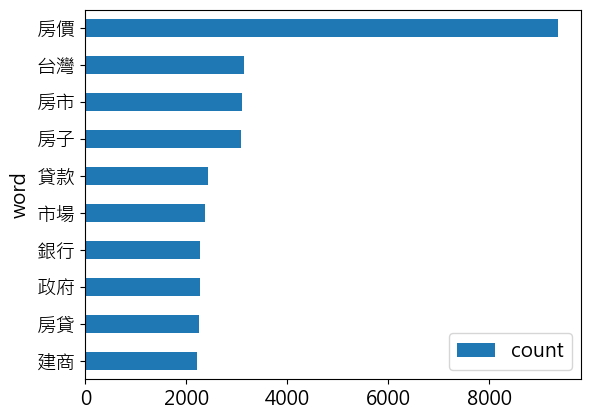

In [94]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

#### 繪製文字雲

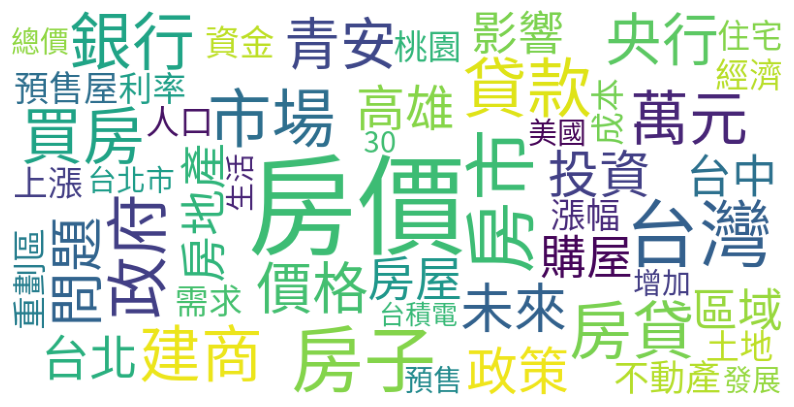

In [95]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 4.10 比較清理前後的文字雲

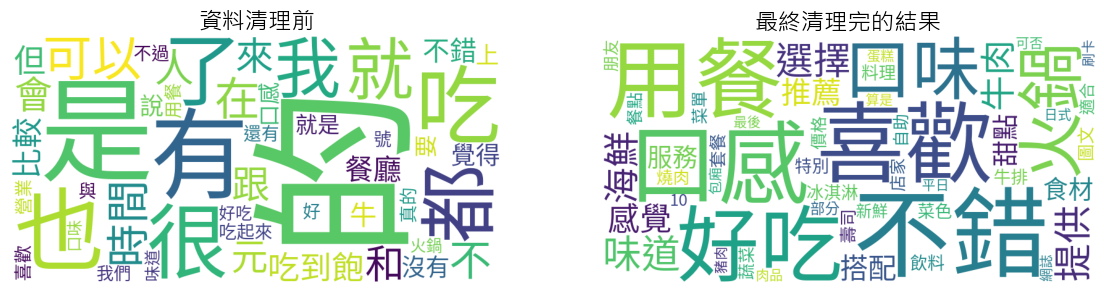

In [ ]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("資料清理前")

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')
plt.title("最終清理完的結果")

plt.show()

儲存clean data，以便後續其他使用

In [ ]:
nostop_df_updated.to_csv("raw_data/clean_zh_data.csv", encoding = 'utf-8',index = False)

資料清理的過程往往是花費做多時間的工程，因為在做完第一次的斷詞、正規化、清除停用字後，我們會發現還是會有許多不重要的字沒有被清理到，或是有些兩個字以上的專有名詞、名詞片語被斷開，因此在進行資料分析前，必須不斷經歷以上過程，更新停用字、字典，以便在後續的分析中能得到重要且正確的分析結果